In [1]:
## Modules 
import pandas as pd
import numpy as np
import scipy as sp
import warnings
warnings.filterwarnings('ignore')

from sklearn import grid_search
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cross_validation import train_test_split
from IPython.display import Image
import pydotplus #make sure you have this installed
import matplotlib.pyplot as plt

from io import StringIO
%matplotlib inline

c:\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\python36\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Exploratory Statistics of the Data 

In [2]:
## load cleaned movie data to a dataeframe
file_name ="data/final_clean_data/final_clean_data.csv"
data = pd.read_csv(file_name)
data.head()

,title,release_date,budget,director,distributor,dom_total_gross,domestic_total_adj_gross,genre,oscar_noms,oscar_wins,...,director_prev_nom,director_prev_win,BAFTA,Golden Globe,Guild,rt_critic_score,rt_audience_score,encoded_director,encoded_genre,encoded_producer
0,The A-Team,6/11/2010,110000000.0,Joe Carnahan,Fox,77222099.0,86741300.0,Action,0,0.0,...,0,0,0,0,0,0.0,0.0,0,0,0
1,A.C.O.D.,10/4/2013,0.0,0,The Film Arcade,175705.0,187900.0,Comedy,0,0.0,...,0,0,0,0,0,0.0,0.0,1,1,1
2,A.I. Artificial Intelligence,6/29/2001,100000000.0,Steven Spielberg,Warner Bros.,78616689.0,124036600.0,Sci-Fi,2,0.0,...,5,2,0,2,0,73.0,64.0,2,2,2
3,Abandon,10/18/2002,25000000.0,Stephen Gaghan,Paramount,10727683.0,16488500.0,Thriller,0,0.0,...,0,0,0,0,0,0.0,0.0,3,3,3
4,The Abandoned,2/23/2007,0.0,0,After Dark Films,1331137.0,1727800.0,Horror,0,0.0,...,0,0,0,0,0,0.0,0.0,1,4,4


In [3]:
data.shape

(10749, 39)

In [4]:
features = ['budget','domestic_total_adj_gross','runtime_mins', 'theaters',
       'days_in_theater', 'year', 'summer','fall', 'holiday', 
       'winter', 'spring', 'PG-13', 'R', 'PG', 'G', 'GP',
       'M/PG', 'director_prev_nom', 'director_prev_win', 'BAFTA',
       'Golden Globe', 'Guild', 'rt_critic_score', 'rt_audience_score',
       'encoded_director', 'encoded_genre', 'encoded_producer']
for i in features:
    print(i," correlation with target: " ,data.oscar_noms.corr(data[i]))

budget  correlation with target:  0.127934462328
domestic_total_adj_gross  correlation with target:  0.340441528402
runtime_mins  correlation with target:  0.348850198379
theaters  correlation with target:  0.113517455707
days_in_theater  correlation with target:  0.15406661862
year  correlation with target:  -0.0931442245754
summer  correlation with target:  -0.0422975350144
fall  correlation with target:  -0.0175212772753
holiday  correlation with target:  0.19774453394
winter  correlation with target:  -0.056625800596
spring  correlation with target:  -0.0735729657029
PG-13  correlation with target:  0.000592137584788
R  correlation with target:  -0.0482429587756
PG  correlation with target:  0.0277232897354
G  correlation with target:  0.0408006247667
GP  correlation with target:  0.00965556445029
M/PG  correlation with target:  0.0135885288273
director_prev_nom  correlation with target:  0.175984552745
director_prev_win  correlation with target:  0.129615108973
BAFTA  correlation 

It was believed that the adjusted gross for a film positively correlated with the number of theaters the film was in and the number of days the film was in theaters. Below the correlation between the columns was found. Based on the positive correlation it was decided to fill the missing values in each column with 0. The runtime of a film was found to have no correlation with the other feature. The missing values for runtime was filled with the average runtime of a film. Given the number of missing values for budget, they were filled with zero. 

In [5]:
## Correlation for theaters and days in theater with Adjusted Gross
print("correlation between adjusted gross and number of theaters: " ,data.domestic_total_adj_gross.corr(data['theaters']))
print("correlation between adjusted gross and days in theater: " ,data.domestic_total_adj_gross.corr(data['days_in_theater']))

correlation between adjusted gross and number of theaters:  0.596444491313
correlation between adjusted gross and days in theater:  0.197874329288


In [6]:
## Fill nan's for budget and (adj) gross with zero and average runtime for         
average_runtime = data.runtime_mins.mean()
data.runtime_mins.fillna(average_runtime, inplace=True)

data.budget.fillna(0,inplace=True)
data.dom_total_gross.fillna(0,inplace=True)
data.domestic_total_adj_gross.fillna(0,inplace=True)
data.theaters.fillna(0,inplace=True)
data.days_in_theater.fillna(0,inplace=True)
data.release_date.fillna(0,inplace=True)

In [7]:
tempDF =data[data['release_date']==0]
print(len(tempDF))
tempDF.head()

91


,title,release_date,budget,director,distributor,dom_total_gross,domestic_total_adj_gross,genre,oscar_noms,oscar_wins,...,director_prev_nom,director_prev_win,BAFTA,Golden Globe,Guild,rt_critic_score,rt_audience_score,encoded_director,encoded_genre,encoded_producer
27,The Accidental Husband - Box Office Mojo,0,0.0,Griffin Dunne,Yari Film Group,0.0,0.0,Romantic Comedy,0,0.0,...,0,0,0,0,0,0.0,0.0,16,5,15
148,The Alibi - Box Office Mojo,0,0.0,0,IDP,0.0,0.0,Crime Comedy,0,0.0,...,0,0,0,0,0,0.0,0.0,1,3,4
223,Altered - Box Office Mojo,0,0.0,0,Rogue Pictures,0.0,0.0,Sci-Fi Horror,0,0.0,...,0,0,0,0,0,0.0,0.0,1,2,4
233,Amarcord - Box Office Mojo,0,0.0,0,Janus Films,126250.0,148100.0,Comedy / Drama,0,0.0,...,0,0,0,0,0,0.0,0.0,1,1,4
259,An American Crime - Box Office Mojo,0,0.0,0,First Look,0.0,0.0,Crime Drama,0,0.0,...,0,0,0,0,0,0.0,0.0,1,3,94


In [8]:
print(len(tempDF[tempDF['director']=='0']))
print(len(tempDF[tempDF['dom_total_gross']==0]))
print(len(tempDF[tempDF['budget']==0]))

66
86
83


Films with no release date were dropped from the dataframe given that the season feature would not be filled. Also many of these films did not have a reported budget, domestic gross, director, rating or genre. Given that these films had very little data they were dropped. 

In [9]:
data = data[data['release_date']!=0]

## The Decision Tree Model

A Decision Tree model was used to determine whether a film will recieve a nomination for the academy awards. Given the most of the 

In [10]:
## Drop columns not being used in the models
drop = ['director', 'distributor','oscar_wins', 'producers', 'rating', 'clean_rating','genre','new_genre']
model_data = data.drop(drop,axis=1)

## Look at columns with missing data
columns_missing_data = [i for i in model_data.columns if np.any(pd.isnull(model_data[i]))]
columns_missing_data

['title']

In [11]:
print(model_data.shape)

(10658, 31)


Two models will be built using each with the entire dataframe and a subset of the dataframe. The first model is a Desicsion Tree. This model is being used to because of list advantages. 

- gridsearch used to find optimal parameters and cross validation
- to show if the model is over fitting
- get an auc_roc curve


It will be compared to Random tree model to assess over fitting

In [12]:
## Removing Films for the year 2017
past_films = model_data[model_data['year']<2017]

## Selecting films that will be predicted on
future_film = model_data[model_data['year']>=2017]

In [13]:
## The Decision Tree model using the entire dataframe. 
target = 'oscar_noms'

dt_data = past_films[features]
features_list = dt_data.columns.tolist()

X = dt_data.values
y = (past_films[target]!=0)*1

In [14]:
## Creating training and testing data for the model
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=.75)

# Parameters and Cross-Validation

GridSearch used to find the best specified parameters for the decision tree model. It goes through each combination of the parameters and reports back the setting with the best score. Also GridSearchCV performs a 3-fold cross validated model for each combination. The max 

In [15]:
## The GridSearchCV
## max_depth':np.arange(10,200,10)

parameters = {'min_samples_leaf':np.arange(1,20,2),'min_samples_split':np.arange(2,20,2)}

tree = DecisionTreeClassifier(criterion='entropy')
clf = grid_search.GridSearchCV(tree, parameters)
clf.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

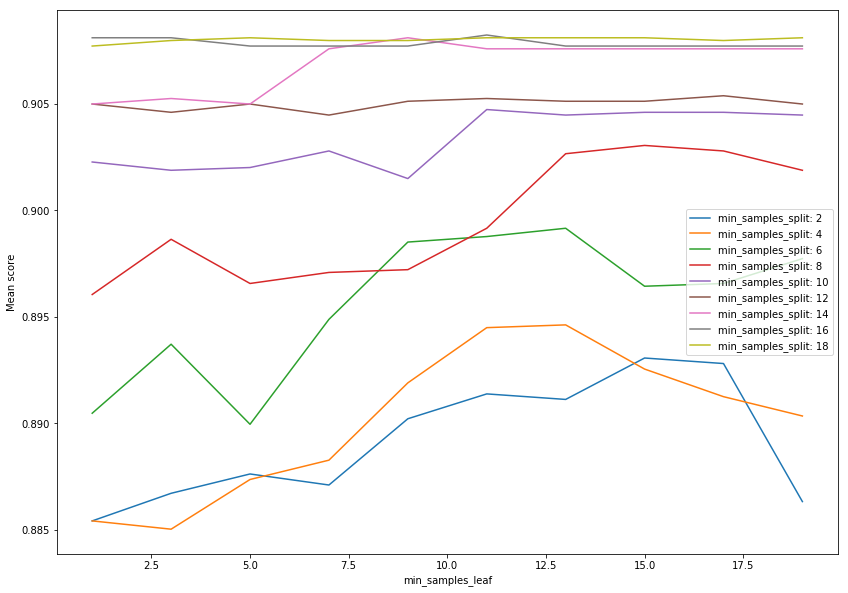

In [16]:
## Plotting the scores 
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(parameters['min_samples_split']), len(parameters['min_samples_leaf']))

plt.figure(figsize=(14,10))

for ind, i in enumerate(parameters['min_samples_split']):
    plt.plot(parameters['min_samples_leaf'], scores[ind], label='min_samples_split: ' + str(i))
plt.legend()
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean score')
plt.show()


In [17]:
print("Best Parameters for model: ", clf.best_score_)
print("Best Parameters for model: ", clf.best_params_)

Best Parameters for model:  0.9082307193778354
Best Parameters for model:  {'min_samples_leaf': 17, 'min_samples_split': 8}


In [18]:
## Training model using the best parameters as determined from the GridSearchCV
tree = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf=19, min_samples_split=16)
tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=16,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

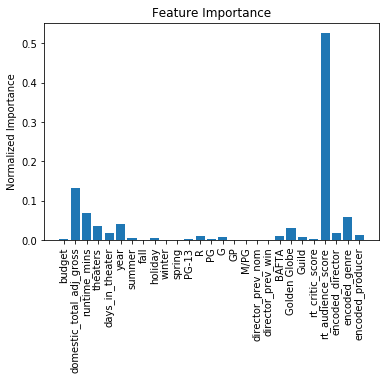

In [19]:
## Looking at the feature importance 
importances = tree.feature_importances_

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]),features_list, rotation=90)

plt.ylabel('Normalized Importance')

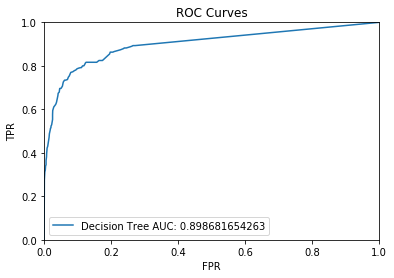

In [20]:
## auc_roc curve indexed 0
fprs_all_films = []
tprs_all_films = []
auc_scores_all_films = []
labels_all_films = ['Decision Tree AUC: ']

fpr, tpr, thresholds = roc_curve(Y_test, tree.predict_proba(X_test)[:,1])

fprs_all_films.append(fpr)
tprs_all_films.append(tpr)
auc_scores_all_films.append(roc_auc_score(Y_test, tree.predict_proba(X_test)[:,1]))

plt.plot(fpr, tpr, label =labels_all_films[0] + str(auc_scores_all_films[0]))

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves")
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

# Films with Reported Budget
Many of the films in the dataframe don't have a reported budget. Since all films cost money for production, the dataframe was created selecting only those films that reported a budget. This model was built to get a better understanding of how budget affects a movie's chances of securing an oscar nomination

In [21]:
## Number of films with no reported budget
len(data[data['budget']==0])

7782

In [22]:
## Data containing budget
film_with_budgetDF = past_films[past_films['budget']!=0]
film_with_budgetDF.shape

(2787, 31)

In [23]:
## setting up data for the Decision Tree for films that have reported budget
target = 'oscar_noms'

dt_data = film_with_budgetDF[features]
features_list = dt_data.columns.tolist()

X = dt_data.values
y = (film_with_budgetDF[target]!=0)*1

## Creating the training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=.75)

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=.75)

In [25]:
# Using Grid search to extract the best parameters for the decision tree
parameters = {'min_samples_leaf':np.arange(1,20,2),'min_samples_split':np.arange(2,20,2)}

tree_with_budget = DecisionTreeClassifier(criterion='entropy')
clf = grid_search.GridSearchCV(tree_with_budget, parameters)
clf.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

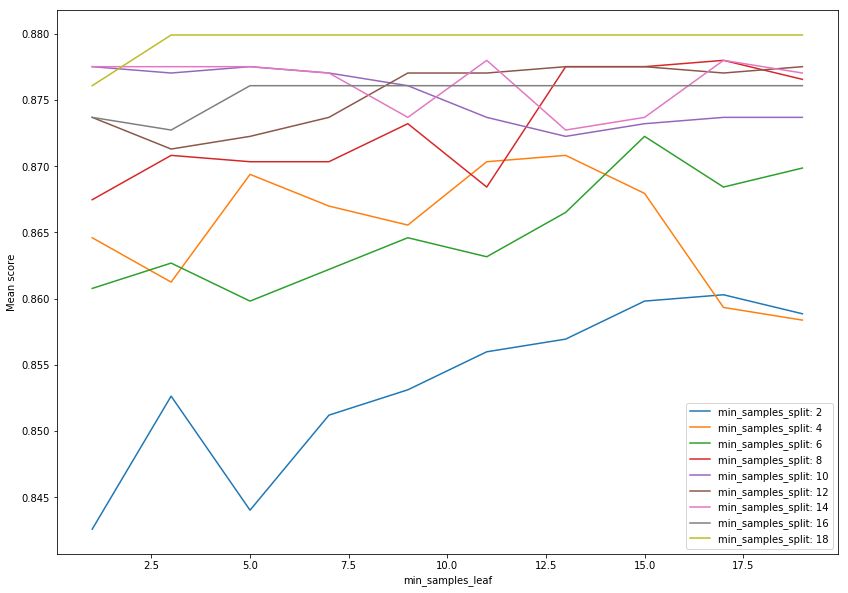

In [26]:
## Plotting the mean AUC scores from cross validation 
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(parameters['min_samples_split']), len(parameters['min_samples_leaf']))

plt.figure(figsize=(14,10))

for ind, i in enumerate(parameters['min_samples_split']):
    plt.plot(parameters['min_samples_leaf'], scores[ind], label='min_samples_split: ' + str(i))
plt.legend()
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean score')
plt.show()


In [27]:
print("Best Parameters for model: ", clf.best_score_)
print("Best Parameters for model: ", clf.best_params_)

Best Parameters for model:  0.8799043062200957
Best Parameters for model:  {'min_samples_leaf': 19, 'min_samples_split': 2}


In [28]:
tree_with_budget = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf=17, min_samples_split=4)
tree_with_budget.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=17, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

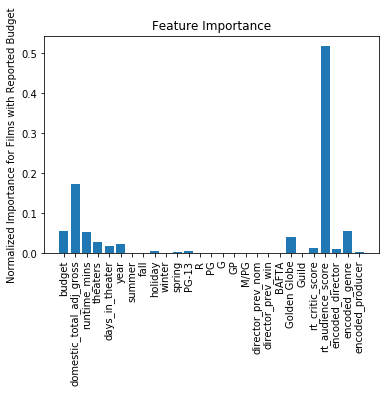

In [29]:
## Looking at the feature importance determined by the decision tree clasifier
importances = tree_with_budget.feature_importances_

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]),features_list, rotation=90)

plt.ylabel('Normalized Importance for Films with Reported Budget')

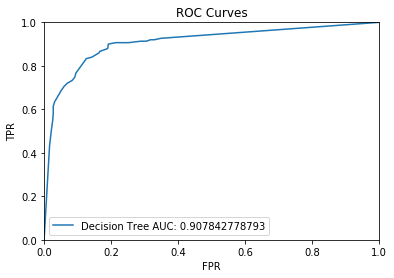

In [30]:
# Plotting the ROC curve for the decision tree with the best parameters obtaine dfrom grid search
labels_films_budget = ['Decision Tree AUC: ']
fprs_films_budget = []
tprs_films_budget = []
auc_scores_films_budget = []

fpr, tpr, thresholds = roc_curve(Y_test, tree_with_budget.predict_proba(X_test)[:,1])

fprs_films_budget.append(fpr)
tprs_films_budget.append(tpr)
auc_scores_films_budget.append(roc_auc_score(Y_test, tree_with_budget.predict_proba(X_test)[:,1]))

plt.plot(fpr, tpr, label =labels_films_budget[0]+ str(auc_scores_films_budget[0]))

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves")
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

# Random Forest Model 

Decision tree classifiers can overfit the data which can lead to false positive and an inaccurate model. We attempted to plot the decsision surface for the decision tree classifier. Due to the number of features (29) the decision surface would not provide an accurate representation of the distribution of the data into the classes. So instead the decision tree classifier was compared to a Random Forest. Random Forest is a robust classifier that is a collection of decision tree and aggregates the trees into a final result. This reduces overfitting and variance. By comparing the two models we would decide which model represented the data more accurately. 

In [31]:
## Selecting the data for the Random Tree Model 
target = 'oscar_noms'

dt_data = past_films[features]
features_list = dt_data.columns.tolist()

X = dt_data.values
y = (past_films[target]!=0)*1

## Creating the training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=.75)

In [32]:
# Using Grid search to extract the best parameters for the decision tree
parameters = {'min_samples_leaf':np.arange(1,20,2),'min_samples_split':np.arange(2,20,2)}

forest = RandomForestClassifier(criterion='entropy')
clf = grid_search.GridSearchCV(forest, parameters)
clf.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

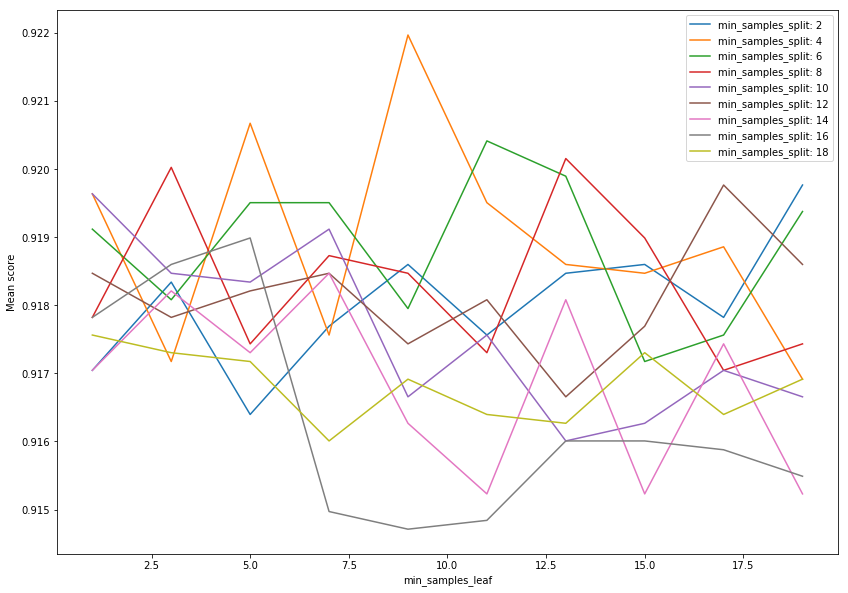

In [33]:
## Plotting the mean AUC scores from the cross validation 
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(parameters['min_samples_split']), len(parameters['min_samples_leaf']))

plt.figure(figsize=(14,10))

for ind, i in enumerate(parameters['min_samples_split']):
    plt.plot(parameters['min_samples_leaf'], scores[ind], label='min_samples_split: ' + str(i))
plt.legend()
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean score')
plt.show()


In [34]:
print("Best Parameters for model: ", clf.best_score_)
print("Best Parameters for model: ", clf.best_params_)

Best Parameters for model:  0.9219701879455606
Best Parameters for model:  {'min_samples_leaf': 3, 'min_samples_split': 12}


In [35]:
## Building the classifier based on the paramters from the Grid Search
forest = RandomForestClassifier(criterion = 'entropy', min_samples_leaf=3, min_samples_split=12)
forest.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

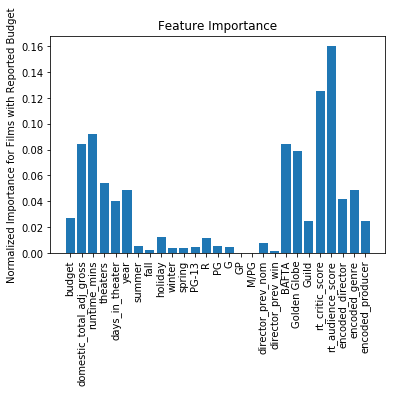

In [36]:
## Looking at the feature importance as determined by the classifier
importances = forest.feature_importances_

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]),features_list, rotation=90)

plt.ylabel('Normalized Importance for Films with Reported Budget')

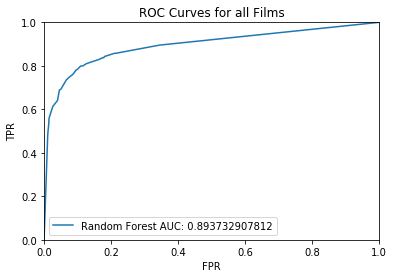

In [37]:
## Plotting the ROC Curve for the Classifier and the AUC score
fpr, tpr, thresholds = roc_curve(Y_test, tree_with_budget.predict_proba(X_test)[:,1])

fprs_all_films.append(fpr)
tprs_all_films.append(tpr)
labels_all_films.append('Random Forest AUC: ')
auc_scores_all_films.append(roc_auc_score(Y_test, tree_with_budget.predict_proba(X_test)[:,1]))

plt.plot(fpr, tpr, label =labels_all_films[1]+ str(auc_scores_all_films[1]))

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves for all Films")
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

# Random Forest with Films that have a Reported Budget


In [38]:
## Selecting the film data with reported budget
target = 'oscar_noms'

dt_data = film_with_budgetDF[features]
features_list = dt_data.columns.tolist()

X = dt_data.values
y = (film_with_budgetDF[target]!=0)*1

## Creating the training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=.75)

In [39]:
# Using Grid search to extract the best parameters for the Random Forest Classifier 
parameters = {'min_samples_leaf':np.arange(1,20,2),'min_samples_split':np.arange(2,20,2)}

forest_with_budget = RandomForestClassifier(criterion='entropy')
clf = grid_search.GridSearchCV(forest_with_budget, parameters)
clf.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

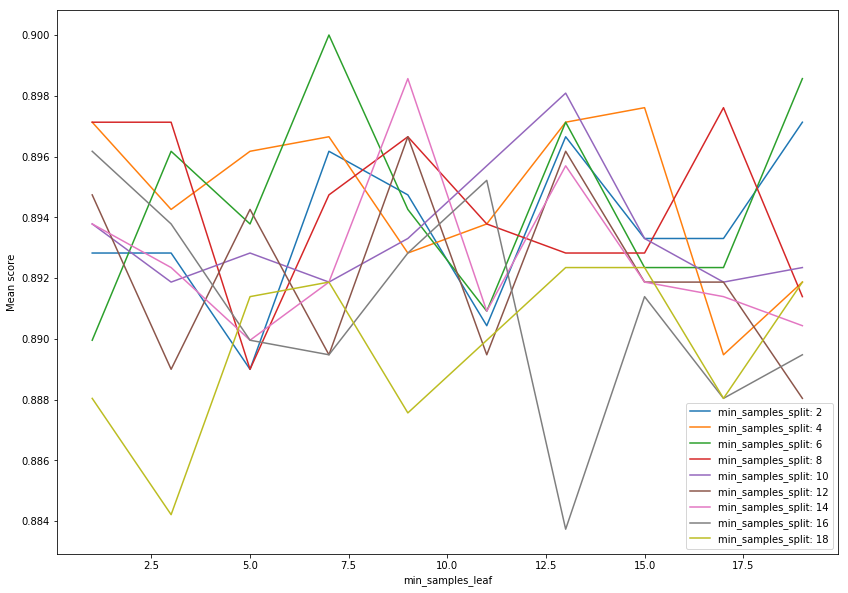

In [40]:
## Plotting the mean scores AUC from the Grid Search cross validation  
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(parameters['min_samples_split']), len(parameters['min_samples_leaf']))

plt.figure(figsize=(14,10))

for ind, i in enumerate(parameters['min_samples_split']):
    plt.plot(parameters['min_samples_leaf'], scores[ind], label='min_samples_split: ' + str(i))
plt.legend()
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean score')
plt.show()


In [41]:
print("Best Parameters for model: ", clf.best_score_)
print("Best Parameters for model: ", clf.best_params_)

Best Parameters for model:  0.9
Best Parameters for model:  {'min_samples_leaf': 5, 'min_samples_split': 12}


In [42]:
## Building the Random Forest Classifier using the parameter determined from the Grid Seacrh
forest_with_budget = RandomForestClassifier(criterion = 'entropy', min_samples_leaf=7, min_samples_split=2)
forest_with_budget.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

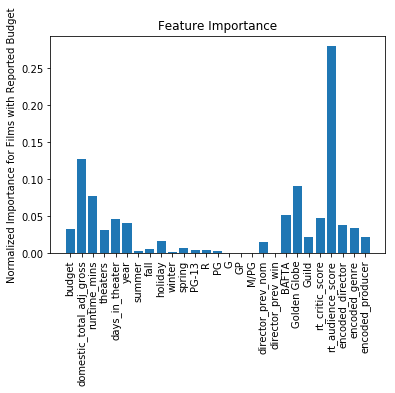

In [43]:
## Looking at the feature importance as determined by the classifier
importances = forest_with_budget.feature_importances_

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]),features_list, rotation=90)

plt.ylabel('Normalized Importance for Films with Reported Budget')

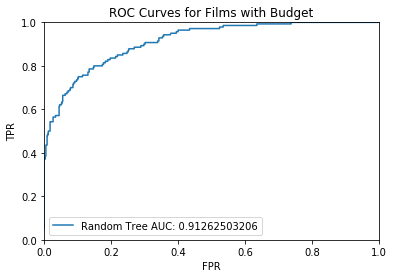

In [44]:
## Plotting the ROC Curve and AUC score for the classifier
labels_films_budget.append('Random Tree AUC: ')
fpr, tpr, thresholds = roc_curve(Y_test, forest_with_budget.predict_proba(X_test)[:,1])

fprs_films_budget.append(fpr)
tprs_films_budget.append(tpr)
auc_scores_films_budget.append(roc_auc_score(Y_test, forest_with_budget.predict_proba(X_test)[:,1]))

plt.plot(fpr, tpr, label = labels_films_budget[1]+ str(auc_scores_films_budget[1]))

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves for Films with Budget")
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

# Comparing the Decision Tree with the Random Forest 

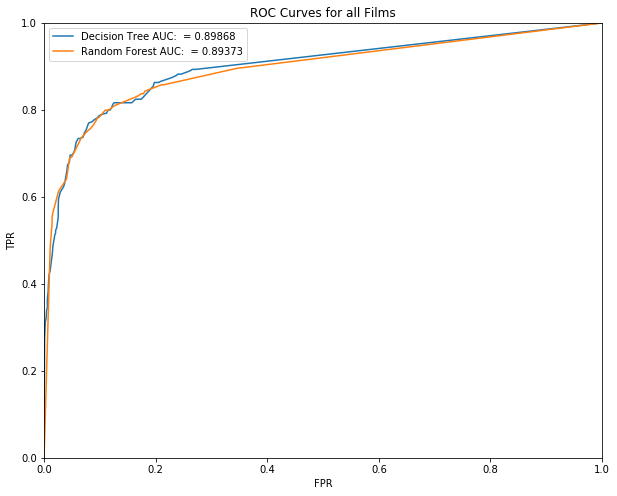

In [45]:
## Comparing the Models ROC Curve and AUC score trained on the entire data set
plt.figure(figsize=(10,8))
for fpr, tpr, label, score in zip(fprs_all_films, tprs_all_films, labels_all_films, auc_scores_all_films): 
    plt.plot(fpr, tpr, label=str(label )+' = %0.5f' %score)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves for all Films")
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

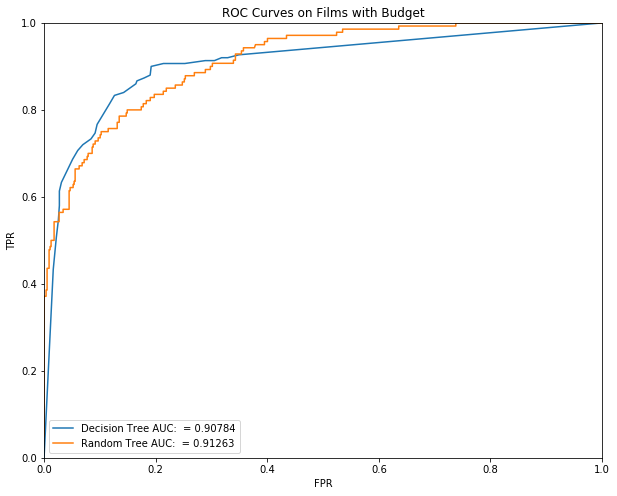

In [46]:
## Comparing the Models ROC Curve and AUC score trained on the subset of films with reported budget
plt.figure(figsize=(10,8))
for fpr, tpr, label, score in zip(fprs_films_budget, tprs_films_budget, labels_films_budget, auc_scores_films_budget): 
    plt.plot(fpr, tpr, label=str(label )+' = %0.5f' %score)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curves on Films with Budget")
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

# Predicting with the best model 
Based on the ROC Curves and AUC score the Random Forest out performed the Decision tree classifier trained on sets of data (all films/films with budget). Below is a prediction for this years Oscar nominations using both Random Forest classifiers.  

In [47]:
print(len(future_film))
future_film.columns

371


Index(['title', 'release_date', 'budget', 'dom_total_gross',
       'domestic_total_adj_gross', 'oscar_noms', 'runtime_mins', 'theaters',
       'days_in_theater', 'year', 'summer', 'fall', 'holiday', 'winter',
       'spring', 'PG-13', 'R', 'PG', 'G', 'GP', 'M/PG', 'director_prev_nom',
       'director_prev_win', 'BAFTA', 'Golden Globe', 'Guild',
       'rt_critic_score', 'rt_audience_score', 'encoded_director',
       'encoded_genre', 'encoded_producer'],
      dtype='object')

In [48]:
pred_data = future_film[features]
film_titles = future_film.title

In [49]:
##Prediction Using Model Trained on all Films!!!!
pred_nominations_all = forest.predict_proba(pred_data)
clf_nominations_all = forest.predict(pred_data)

In [50]:
pred_df_all = pd.DataFrame({'titles': future_film.title,'Nomination_classification':clf_nominations_all ,'Nominations_Predictions': pred_nominations_all.T[1], 'year':future_film.year,'release_date':future_film.release_date})

In [51]:
## Predictions!!!!
pred_df_all = pred_df_all.sort_values('Nominations_Predictions',ascending=False)
pred_df_all.head(10)

,Nomination_classification,Nominations_Predictions,release_date,titles,year
1865,1,0.983333,9/1/2017,Close Encounters of the Third Kind,2017.0
9333,1,0.955556,12/1/2017,Titanic,2017.0
760,1,0.882438,3/17/2017,Beauty and the Beast,2017.0
6945,1,0.865339,2/24/2017,Pelle the Conqueror,2017.0
4687,1,0.547514,6/2/2017,"I, Daniel Blake",2017.0
1211,1,0.529127,3/31/2017,The Boss Baby,2017.0
2859,0,0.442471,7/28/2017,The Emoji Movie,2017.0
10312,0,0.424654,6/2/2017,Wonder Woman,2017.0
1535,0,0.376064,6/2/2017,Captain Underpants: The First Epic Movie,2017.0
1895,0,0.373853,11/22/2017,Coco,2017.0


In [52]:
##Prediction Using Model Trained on Films with Budget!!!!
pred_nominations_budget = forest_with_budget.predict_proba(pred_data)
clf_nominations_budget = forest_with_budget.predict(pred_data)

In [53]:
pred_df_budget = pd.DataFrame({'titles': future_film.title,'Nomination_classification':clf_nominations_budget ,'Nominations_Predictions': pred_nominations_budget.T[1], 'year':future_film.year,'release_date':future_film.release_date})

In [54]:
pred_df_budget = pred_df_budget.sort_values('Nominations_Predictions',ascending=False)
pred_df_budget.head(10)

,Nomination_classification,Nominations_Predictions,release_date,titles,year
9333,1,0.980000,12/1/2017,Titanic,2017.0
760,1,0.903022,3/17/2017,Beauty and the Beast,2017.0
1865,1,0.885714,9/1/2017,Close Encounters of the Third Kind,2017.0
4687,1,0.743750,6/2/2017,"I, Daniel Blake",2017.0
10312,1,0.741524,6/2/2017,Wonder Woman,2017.0
6945,1,0.570984,2/24/2017,Pelle the Conqueror,2017.0
8604,1,0.534938,7/7/2017,Spider-Man: Homecoming,2017.0
4019,0,0.484296,5/5/2017,Guardians of the Galaxy Vol. 2,2017.0
5804,0,0.431841,3/3/2017,Logan,2017.0
9250,0,0.387517,11/3/2017,Thor: Ragnarok,2017.0


# Analysis of Prediction

After running both models two films that were originally released in the 1980's both which recieved Oscar nominations
1. Close Encounters of the Third Kind
2. Pelle the Conqueror
The reason these two films are included in the data set is they both were re-released over the summer of 2017. The data from Box Office Mojo included these two films as current releases. Many film are remade using the same title, each remake represents a unique row in the data set. Therefore duplicates could not be removed based on film title. 

Beauty and the Beast remake is predicted to recieve an Oscar nomination based on both classifiers. 

In [55]:
film = future_film[future_film['title'] == 'Beauty and the Beast']

film[['title','budget','domestic_total_adj_gross','runtime_mins', 'BAFTA', 'Golden Globe',
       'rt_critic_score', 'rt_audience_score']]

,title,budget,domestic_total_adj_gross,runtime_mins,BAFTA,Golden Globe,rt_critic_score,rt_audience_score
760,Beauty and the Beast,160000000.0,507208000.0,129.0,0,1,93.0,92.0


The most important features contributing to a films nomination are 

1. budget
2. domestic_total_adj_gross
3. runtime_mins
4. rt_critic_score
5. rt_audience_score

These features all have a strong positive correlation with the target variable. As shown above Beauty and the Beast scores highly in all 5 of these features. The outcomes of these prediction depend on the time when these models are run. It will be interesting to run these models again on the 2017 films once the Golden Globes and other award ceremonies have been annouced.

# Application

This model can be used by studio to analyse and decide which films needs investement in what areas so as to maximize their probabaility of getting nominated for Oscars. They can also use this model to decide on which films to advertise, use Oscar consaultants and selected screening to influence memeber of the Academy. The data set used to build these models initialy contained a lot of missing values for a number of features. For example budget and ratings. A studio would be able to  easily retieve this information. Thereby filling the missing data which is integral to building a accurate model. 